In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/11785/recitation08part02

/content/gdrive/MyDrive/11785/recitation08part02


In [ ]:
! pip install python-Levenshtein

In [ ]:
! pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c 11-785-fall-20-homework-4-part-2

In [ ]:
! git clone https://github.com/salesforce/awd-lstm-lm.git

Cloning into 'awd-lstm-lm'...
remote: Enumerating objects: 137, done.
remote: Total 137 (delta 0), reused 0 (delta 0), pack-reused 137
Receiving objects: 100% (137/137), 57.62 KiB | 366.00 KiB/s, done.
Resolving deltas: 100% (73/73), done.


In [ ]:
! cp /content/awd-lstm-lm/weight_drop.py /content/gdrive/MyDrive/11785/recitation08part02

# dataloader

In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset 
from torch.nn.utils.rnn import *

'''
Loading all the numpy files containing the utterance information and text information
'''
def load_data(): 
    speech_train = np.load('./data/train.npy', allow_pickle=True, encoding='bytes')
    speech_valid = np.load('./data/dev.npy', allow_pickle=True, encoding='bytes')
    speech_test = np.load('./data/test.npy', allow_pickle=True, encoding='bytes')

    transcript_train = np.load('./data/train_transcripts.npy', allow_pickle=True,encoding='bytes')
    transcript_valid = np.load('./data/dev_transcripts.npy', allow_pickle=True,encoding='bytes')

    return speech_train, speech_valid, speech_test, transcript_train, transcript_valid


'''
Transforms alphabetical input to numerical input, replace each letter by its corresponding 
index from letter_list
'''
def transform_letter_to_index(transcript, letter_list):
    '''
    :param transcript :(N, ) Transcripts are the text input
    :param letter_list: Letter list defined above
    :return letter_to_index_list: Returns a list for all the transcript sentence to index
    '''
    letter_to_index = []
    for sentence in transcript:
        sent=""
        for word in sentence:
          word = word.decode()
          sent+=(word + ' ')
        sent = sent[:-1]
        lst = []
        lst.append(letter_list.index('<sos>'))
        for c in sent:
          lst.append(letter_list.index(c))
        lst.append(letter_list.index('<eos>')) 
        letter_to_index.append(lst)
    return letter_to_index


'''
Optional, create dictionaries for letter2index and index2letter transformations
'''
def create_dictionaries(letter_list):
    letter2index = dict()
    index2letter = dict()
    return letter2index, index2letter


class Speech2TextDataset(Dataset):
    '''
    Dataset class for the speech to text data, this may need some tweaking in the
    getitem method as your implementation in the collate function may be different from
    ours. 
    '''
    def __init__(self, speech, text=None, isTrain=True):
        self.speech = speech
        self.isTrain = isTrain
        if (text is not None):
            self.text = text

    def __len__(self):
        return self.speech.shape[0]

    def __getitem__(self, index):
        if (self.isTrain == True):
            return torch.tensor(self.speech[index].astype(np.float32)), torch.tensor(self.text[index])
        else:
            return torch.tensor(self.speech[index].astype(np.float32))


def collate_train(batch):
    ### Return the padded speech and text data, and the length of utterance and transcript ###
    # pass 
    #print('hi')
    #print(len(batch))
    data = [torch.Tensor(item[0]) for item in batch]  # just form a list of tensor
    lengths_x = torch.tensor([ t.shape[0] for t in data ]) # torch.tensor(
    #print('lenx',lengths_x)
    target = [item[1][1:] for item in batch] #torch.Tensor(
    lengths_y = torch.tensor([ t.shape[0] for t in target ])
    #print('leny',lengths_y)
    data = pad_sequence(data,batch_first=True) # CCCCHHEEECCKKK BATCH FIRST!!!
    target = pad_sequence(target,batch_first=True)
    #target = torch.LongTensor(target)
    #X_lens = torch.LongTensor([len(seq) for seq in data])
    #Y_lens = torch.LongTensor([len(seq) for seq in target])
    
    return data, target.long(), lengths_x.long(), lengths_y.long() # X_lens, Y_lens


def collate_test(batch_data):
    ### Return padded speech and length of utterance ###
    pass 

# model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.utils as utils
from embed_regularize import embedded_dropout
from locked_dropout import LockedDropout
from weight_drop import WeightDrop

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

class Attention(nn.Module):
    '''
    Attention is calculated using key, value and query from Encoder and decoder.
    Below are the set of operations you need to perform for computing attention:
        energy = bmm(key, query)
        attention = softmax(energy)
        context = bmm(attention, value)
    '''
    def __init__(self):
        super(Attention, self).__init__()

    def forward(self, query, key, value, lens):
        '''
        :param query :(batch_size, hidden_size) Query is the output of LSTMCell from Decoder
        :param keys: (batch_size, max_len, encoder_size) Key Projection from Encoder
        :param values: (batch_size, max_len, encoder_size) Value Projection from Encoder
        :return context: (batch_size, encoder_size) Attended Context
        :return attention_mask: (batch_size, max_len) Attention mask that can be plotted  
        : lens - (batch_size,)
        '''
        # Compute (batch_size, max_len) attention logits. "bmm" stands for "batch matrix multiplication".
        # Input shape of bmm:  (batch_szie, max_len, hidden_size), (batch_size, hidden_size, 1) 
        # Output shape of bmm: (batch_size, max_len, 1)

        #ENERGY = (batch_size x maxlen x encoder_size) x (batch_size, hidden_size , 1)

        attention = torch.bmm(key, query.unsqueeze(2)).squeeze(2)        # batch_size x maxlen
        
        # Create an (batch_size, max_len) boolean mask for all padding positions
        # Make use of broadcasting: (1, max_len), (batch_size, 1) -> (batch_size, max_len)
        mask = torch.arange(key.size(1)).unsqueeze(0) >= lens.unsqueeze(1)  #(batch_size, max_len) where lens are original seq lens
        mask = mask.to(DEVICE)
        # Set attention logits at padding positions to negative infinity.
        attention.masked_fill_(mask, -1e9)                  ##(batch_size, max_len)
        
        # Take softmax over the "source length" dimension.
        attention = nn.functional.softmax(attention, dim=1) #.to(DEVICE)       # batch_size x maxlen
        # context = torch.bmm(attention, value.unsqueeze(2)).squeeze(2) ### CHECK!
        # Compute attention-weighted sum of context vectors
        # Input shape of bmm: (batch_size, 1, max_len), (batch_size, max_len, hidden_size) 
        # Output shape of bmm: (batch_size, 1, hidden_size)
        context = torch.bmm(attention.unsqueeze(1), value).squeeze(1)    ## batch_size x encoder_size
        
        # attention vectors are returned for visualization
        return  context, attention         #out, attention


class pBLSTM(nn.Module):
    '''
    Pyramidal BiLSTM
    The length of utterance (speech input) can be hundereds to thousands of frames long.
    The Paper reports that a direct LSTM implementation as Encoder resulted in slow convergence,
    and inferior results even after extensive training.
    The major reason is inability of AttendAndSpell operation to extract relevant information
    from a large number of input steps.
    '''
    def __init__(self, input_dim, hidden_dim):
        super(pBLSTM, self).__init__()
        # CCHHEECCKKK BATCH FIRST !!!!!!!
        self.blstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=1, bidirectional=True,batch_first=True)
        self.blstm = WeightDrop(self.blstm, ['weight_hh_l0'], dropout= 0.2)
        self.lockdrop = LockedDropout()
    def forward(self, x):
        '''
        :param x :(N, T) input to the pBLSTM
        :return output: (N, T, H) encoded sequence from pyramidal Bi-LSTM 
        '''
        
        x, lens_unpacked = utils.rnn.pad_packed_sequence(x,batch_first= True)
        x = self.lockdrop(x,dropout=0.2)
        N = x.size(0)
        T = x.size(1)
        feat = x.size(2)
        if T%2 != 0:
          x = x[:,:-1,:]
        '''x = x.permute(1,0,2)
        x = x.reshape(N,int(T/2),feat*2)
        X = x.permute(1,0,2)'''
        #x = x.contiguous().reshape(N,int(T//2),feat*2)
        x = x.contiguous().view(N,int(T//2),feat*2)
        input_x = utils.rnn.pack_padded_sequence(x, lengths=lens_unpacked//2, batch_first= True, enforce_sorted=False)
        
        output,hidden = self.blstm(input_x)
        return output,hidden


class Encoder(nn.Module):
    '''
    Encoder takes the utterances as inputs and returns the key and value.
    Key and value are nothing but simple projections of the output from pBLSTM network.
    '''
    def __init__(self, input_dim, hidden_dim, value_size=256,key_size=256):
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=1, bidirectional=True, batch_first=True).cuda()
        self.lstm = WeightDrop(self.lstm, ['weight_hh_l0'], dropout= 0.2)
        self.lockdrop = LockedDropout()
        ### Add code to define the blocks of pBLSTMs! ###

        self.pLSTM_layer1 = pBLSTM(hidden_dim*4,hidden_dim).cuda()
        self.pLSTM_layer2 = pBLSTM(hidden_dim*4,hidden_dim).cuda() 
        self.pLSTM_layer3 = pBLSTM(hidden_dim*4,hidden_dim).cuda()

        self.key_network = nn.Linear(hidden_dim*2, value_size).cuda()
        self.value_network = nn.Linear(hidden_dim*2, key_size).cuda()

    def forward(self, x, lens):
      # BATCH FIRST TRUE !!!!
        rnn_inp = utils.rnn.pack_padded_sequence(x, lengths=lens, batch_first= True, enforce_sorted=False)
        outputs, _ = self.lstm(rnn_inp)

        ### Use the outputs and pass it through the pBLSTM blocks! ###

        output, _ = self.pLSTM_layer1(outputs)
        output, _ = self.pLSTM_layer2(output)
        outputs, _ = self.pLSTM_layer3(output)

        # BATCH FIRST TRUE !!!!
        linear_input, lengths = utils.rnn.pad_packed_sequence(outputs,batch_first= True)
        linear_input = self.lockdrop(linear_input,dropout=0.2)
        keys = self.key_network(linear_input)
        value = self.value_network(linear_input)

        return keys, value, lengths


class Decoder(nn.Module):
    '''
    As mentioned in a previous recitation, each forward call of decoder deals with just one time step, 
    thus we use LSTMCell instead of LSLTM here.
    The output from the second LSTMCell can be used as query here for attention module.
    In place of value that we get from the attention, this can be replace by context we get from the attention.
    Methods like Gumble noise and teacher forcing can also be incorporated for improving the performance.
    '''
    def __init__(self, vocab_size, hidden_dim, value_size=256, key_size=256, isAttended=True):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim, padding_idx=0)
        self.lstm1 = nn.LSTMCell(input_size=hidden_dim + value_size, hidden_size=hidden_dim)
        self.lstm2 = nn.LSTMCell(input_size=hidden_dim, hidden_size=key_size)
#embedded_dropout
        self.isAttended = isAttended
        if (isAttended == True):
            self.attention = Attention()
# HHHARDDDD CCCOOODDDDDEEEDDDD
        self.character_prob = nn.Linear(256, vocab_size)
        self.character_prob.weight = self.embedding.weight

        self.fc1 = nn.Linear(256, 256)
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(256)
        self.bn2 = nn.BatchNorm1d(256)
        #self.fc2 = nn.Linear(256, 256)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(256, 256)
        #self.fc4 = nn.Linear(config.vocab_size + config.vocab_size, config.vocab_size)
        self.init_weights()
    def init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.character_prob.bias.data.zero_()
        self.character_prob.weight.data.uniform_(-initrange, initrange)

    def forward(self, epoch, key, values, lens, text=None, isTrain=True):
        '''
        :param key :(T, N, key_size) Output of the Encoder Key projection layer.  (Batch x max len. x encoder_size)
        :param values: (T, N, value_size) Output of the Encoder Value projection layer.  (Batch x max len x encoder_size)
        :param text: (N, text_len) Batch input of text with text_length.  (batch_size x text_len). 
        :param isTrain: Train or eval mode
        :return predictions: Returns the character perdiction probability 
        '''
        num_comb = 100
        batch_size = key.shape[0]     #key.shape[1]
        sos = torch.Tensor(np.array([33]*batch_size)).unsqueeze(1)
        sos = sos.to(DEVICE).long()
        text = torch.cat((sos,text),1)
        text = text.to(DEVICE)
        if (isTrain == True):
            max_len =  text.shape[1]
            embeddings = self.embedding(text) # y values
        else:
            max_len = 600 

        predictions = []
        hidden_states = [None, None]
        hid_dim = values.size(2) # same as encoder_size
        context = values[:,0,:].reshape(values.size(0),values.size(2)) # initialise context with 0. torch.zeros(batch_size, hid_dim).to(DEVICE)
        prediction = (torch.ones(batch_size, 1)*33).to(DEVICE)  #.  torch.zeros(batch_size,1).to(DEVICE)
        all_attentions = []
        if epoch < 5:
            tf_rate = 0.9
        elif epoch >=5 and epoch < 10:
            tf_rate = 0.85
        elif epoch >=10 and epoch < 15:
            tf_rate = 0.75
        elif epoch >=15 and epoch < 20:
            tf_rate = 0.7
        elif epoch >=20 and epoch < 25:
            tf_rate = 0.65
        elif epoch >=25 and epoch < 30:
            tf_rate = 0.6
        else:
            tf_rate = 0.55
        for i in range(max_len-1): 
            # * Implement Gumble noise and teacher forcing techniques 
            # * When attention is True, replace values[i,:,:] with the context you get from attention.
            # * If you haven't implemented attention yet, then you may want to check the index and break 
            #   out of the loop so you do not get index out of range errors. 
            
            if (isTrain):
                # teacher forcing
                p = np.random.random()
                if p < tf_rate:
                    char_embed = embeddings[:,i,:]    
                else: 
                    char_embed = self.embedding(prediction.argmax(dim=-1))  
            else:
                char_embed = self.embedding(prediction.argmax(dim=-1))

            inp = torch.cat([char_embed, context], dim=1) # inp = batch x (hidden dim + hidden dim)
            hidden_states[0] = self.lstm1(inp, hidden_states[0]) # h = batch x hidden & c = batch x hidden

            inp_2 = hidden_states[0][0]
            hidden_states[1] = self.lstm2(inp_2, hidden_states[1]) 

            ### Compute attention from the output of the second LSTM Cell ###
            output = hidden_states[1][0]    # query. output = batch x hidden
            context,attention = self.attention(output,key, values,lens) #batch_size x encoder_size
            all_attentions.append(attention.detach())
            fc_output = self.relu1(self.bn1(self.fc1(output)))
            context_out = self.relu2(self.bn2(self.fc3(context)))
            context_out = context_out.to(DEVICE)
            #print('shape check',torch.cat([fc_output, context_out], dim=1).shape)
            prediction = self.character_prob(torch.cat([fc_output, context_out], dim=1)) # s, c # batch x (enc_size + hidden) pred = b x vocab
            predictions.append(prediction.unsqueeze(1)) # b x 1 x vocab
        all_attentions = torch.stack(all_attentions, dim=1)

        return torch.cat(predictions, dim=1) , all_attentions  # b x maxlen x vocab


class Seq2Seq(nn.Module):
    '''
    We train an end-to-end sequence to sequence model comprising of Encoder and Decoder.
    This is simply a wrapper "model" for your encoder and decoder.
    '''
    def __init__(self, input_dim, vocab_size, hidden_dim, value_size=256, key_size=256, isAttended=False):
        super(Seq2Seq, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim)
        self.decoder = Decoder(vocab_size, hidden_dim)

    def forward(self, epoch, speech_input, speech_len, text_input=None, isTrain=True):
        key, value, lens = self.encoder(speech_input, speech_len)
        if (isTrain == True):
            predictions, att = self.decoder(epoch, key, value, lens, text_input)
        else:
            predictions, att = self.decoder(epoch, key, value, lens, text=text_input, isTrain=False)
        return predictions, att


# util

In [ ]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import numpy as np

def plot_attn_flow(attn_mask, path):
    fig = plt.figure()
    plt.imshow(attn_mask, cmap="hot")
    plt.show()
    fig.savefig(path)
    #plt.imsave(path, fig, cmap='hot')
    plt.close()
    return 

def plot_grad_flow(named_parameters, path):
    ave_grads = []
    max_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            if(p is not None):
                layers.append(n)
                ave_grads.append(p.grad.abs().mean())
                max_grads.append(p.grad.abs().max())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    #plt.tight_layout()
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])
    plt.show()
    plt.savefig(path)
    return plt, max_grads


# train test

In [ ]:
import time
import torch
from Levenshtein import distance
### Add Your Other Necessary Imports Here! ###

device = 'cuda' if torch.cuda.is_available() else 'cpu'
LETTER_LIST = ['<pad>', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', \
               'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '-', "'", '.', '_', '+', ' ','<sos>','<eos>']
def train(model, train_loader, criterion, optimizer, epoch):
    model.train()
    model.to(device)
    start = time.time()

    # 1) Iterate through your loader
    for i, batch in enumerate(train_loader):
        #model.train()
        X,Y,len_x, len_y=batch # x = B X maxlen X 40 Y = B X maxlen
        print('i',i)
        x = X.to(device) #Variable(X.type(Tensor)).cuda() #X.cuda() #to(device) #Variable(X.type(Tensor)).cuda() # X.long().cuda() #Variable(X.type(Tensor)).cuda()
        #print(x.device)
        
        y = Y.to(device) # Variable(Y.type(Tensor)).cuda() #Y.cuda() #.to(device) #Variable(Y.type(Tensor)).cuda() # Y.long().cuda() #Variable(Y.type(Tensor)).cuda()
        #print(y.device)
        #len_x=len_x.to(device) 
        #len_y=len_y.to(device) 
        # torch.autograd.set_detect_anomaly(True)

        # 2) Use torch.autograd.set_detect_anomaly(True) to get notices about gradient explosion
        
            # 3) Set the inputs to the device.

            # 4) Pass your inputs, and length of speech into the model.
        optimizer.zero_grad()
        pred, att = model(epoch, x, len_x, text_input=y, isTrain=True)
        # for each text sequence mask = batch x maxlen   
        
        mask = torch.arange(y.size(1)).unsqueeze(0) >= len_y.unsqueeze(1)
        mask = mask.to(device)
        #pred.masked_fill_(mask, 0) # batch x maxlen x vocab
        
            # 5) Generate a mask based on the lengths of the text to create a masked loss. 
            # 5.1) Ensure the mask is on the device and is the correct shape.

            # 6) If necessary, reshape your predictions and origianl text input 
            # 6.1) Use .contiguous() if you need to. 

            # 7) Use the criterion to get the loss.
        #loss = 0
        #for i in range(y.size(0)):
            #index_ignore = torch.arange(len_y[i,:],y.size(1))
            #loss + = criterion(pred[i,:,:].contiguous(), y[i,:].long(), )
        loss = criterion(pred.contiguous().view(-1, pred.size(2)), y.long().view(-1)) # batch x maxlen
        
            # 8) Use the mask to calculate a masked loss.           ----> ???
        loss.masked_fill_(mask.view(-1),0)
            # 9) Run the backward pass on the masked loss.
        loss =  loss.mean()
        loss.backward()
            # 10) Use torch.nn.utils.clip_grad_norm(model.parameters(), 2)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 2)          
            # 11) Take a step with your optimizer
        optimizer.step()
        if i == 5:
            att = att[0, :len_y[0] - 1, :len_x[0]].cpu().numpy()
            plot_attn_flow(att, path='/content/gdrive/MyDrive/11785/recitation08part02/exp2/attn_weight/attention'+str(epoch+1)+'.jpg')
        
        

            # 12) Normalize the masked loss
        #loss /= loss.sum()
        print("epoch", epoch+1)
        print(' batch Loss train:', loss.item())

            # 13) Optionally print the training loss after every N batches
    
    print('total epoch Loss train:', loss.mean())

    end = time.time()

def val(model, val_loader):
    ### Write your val code here! ###
    
    model.eval()
    for i, batch in enumerate(val_loader):
        speech_input,text_input, speech_len, text_lens = batch
        speech_input = speech_input.to(device)
        text_input = text_input.to(device)
        #speech_len = speech_len.to(device)
        text_lens = text_lens.to(device)

        #print(text_input.shape)
        maxlen = text_input.shape[1]

        pred, _ = model(0,speech_input, speech_len, text_input=text_input, isTrain=False)
        edit_dist=0
        
        #characters = ''
        for j in range(text_input.shape[0]):
        # For the i-th sample in the batch, get the best output
          seq = pred[j,:,:].argmax(dim=-1)
          bestsound=''
          ystring=''
          for k in range(maxlen):
            if text_input[j][k].item() == 34 or text_input[j][k].item() == 0:
              break
            else:
              ystring += LETTER_LIST[text_input[j][k].item()] 
          for k in seq:
              if k == 34 or k == 0:
                  break
              else:
                  bestsound += LETTER_LIST[k]
          #print('pred',bestsound)
          
          #print('label',ystring)
          
          edit_dist+=distance(ystring, bestsound)
        print('dist = ',edit_dist/text_input.shape[0])

    

def test(model, test_loader):
    ### Write your test code here! ###
    model.eval()
    predict = []
    for i, batch in enumerate(test_loader):
        speech_input, speech_len = batch
        speech_input = speech_input.to(device)
        
        #speech_len = speech_len.to(device)
        

        #print(text_input.shape)
        

        pred, _ = model(0,speech_input, speech_len, text_input=None, isTrain=False)
        
        
        #characters = ''
        for j in range(speech_input.shape[0]):
        # For the i-th sample in the batch, get the best output
          print(j)
          seq = pred[j,:,:].argmax(dim=-1)
          bestsound=''
          for k in seq:
              if k == 34 or k == 0:
                  break
              else:
                  bestsound += LETTER_LIST[k]
          predict.append(bestsound)
          #print('pred',bestsound)
          #print()
          #print('label',ystring)
          #print()
          
    return predict

# load model

# main

Applying weight drop of 0.2 to weight_hh_l0
Applying weight drop of 0.2 to weight_hh_l0
Applying weight drop of 0.2 to weight_hh_l0
Applying weight drop of 0.2 to weight_hh_l0
(1067, 40)
446
i 0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:585: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.num_layers, self.dropout, self.training, self.bidirectional)


epoch 31
 batch Loss train: 0.07918063551187515
i 1
epoch 31
 batch Loss train: 0.07648749649524689
i 2
epoch 31
 batch Loss train: 0.06444495171308517
i 3
epoch 31
 batch Loss train: 0.07763517647981644
i 4
epoch 31
 batch Loss train: 0.08324217796325684
i 5


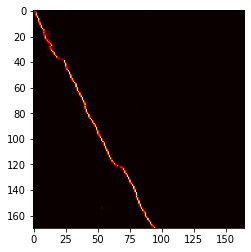

epoch 31
 batch Loss train: 0.12833814322948456
i 6
epoch 31
 batch Loss train: 0.11012420058250427
i 7
epoch 31
 batch Loss train: 0.07828918844461441
i 8
epoch 31
 batch Loss train: 0.10164443403482437
i 9
epoch 31
 batch Loss train: 0.10428349673748016
i 10
epoch 31
 batch Loss train: 0.09883514791727066
i 11
epoch 31
 batch Loss train: 0.10816346853971481
i 12
epoch 31
 batch Loss train: 0.08052564412355423
i 13
epoch 31
 batch Loss train: 0.1081700250506401
i 14
epoch 31
 batch Loss train: 0.06366433203220367
i 15
epoch 31
 batch Loss train: 0.08887051790952682
i 16
epoch 31
 batch Loss train: 0.06581945717334747
i 17
epoch 31
 batch Loss train: 0.09720596671104431
i 18
epoch 31
 batch Loss train: 0.08290782570838928
i 19
epoch 31
 batch Loss train: 0.10261914134025574
i 20
epoch 31
 batch Loss train: 0.0850779339671135
i 21
epoch 31
 batch Loss train: 0.08650362491607666
i 22
epoch 31
 batch Loss train: 0.08559397608041763
i 23
epoch 31
 batch Loss train: 0.09157309681177139
i 24

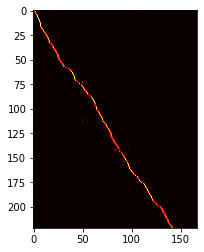

epoch 32
 batch Loss train: 0.06021897494792938
i 6
epoch 32
 batch Loss train: 0.09735576063394547
i 7
epoch 32
 batch Loss train: 0.10926084220409393
i 8
epoch 32
 batch Loss train: 0.06905844807624817
i 9
epoch 32
 batch Loss train: 0.06475061923265457
i 10
epoch 32
 batch Loss train: 0.09215962886810303
i 11
epoch 32
 batch Loss train: 0.08417818695306778
i 12
epoch 32
 batch Loss train: 0.07244747877120972
i 13
epoch 32
 batch Loss train: 0.05919743701815605
i 14
epoch 32
 batch Loss train: 0.07234242558479309
i 15
epoch 32
 batch Loss train: 0.0831424742937088
i 16
epoch 32
 batch Loss train: 0.11475033313035965
i 17
epoch 32
 batch Loss train: 0.08875316381454468
i 18
epoch 32
 batch Loss train: 0.09924650192260742
i 19
epoch 32
 batch Loss train: 0.10162286460399628
i 20
epoch 32
 batch Loss train: 0.08493021130561829
i 21
epoch 32
 batch Loss train: 0.0905766487121582
i 22
epoch 32
 batch Loss train: 0.10401349514722824
i 23
epoch 32
 batch Loss train: 0.0719422921538353
i 24


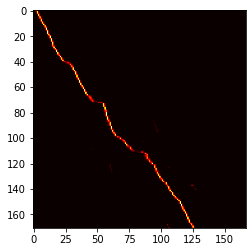

epoch 33
 batch Loss train: 0.07035703212022781
i 6
epoch 33
 batch Loss train: 0.09517643600702286
i 7
epoch 33
 batch Loss train: 0.06125008687376976
i 8
epoch 33
 batch Loss train: 0.11154302209615707
i 9
epoch 33
 batch Loss train: 0.05982832983136177
i 10
epoch 33
 batch Loss train: 0.06329385936260223
i 11
epoch 33
 batch Loss train: 0.09048189967870712
i 12
epoch 33
 batch Loss train: 0.10175181180238724
i 13
epoch 33
 batch Loss train: 0.08373771607875824
i 14
epoch 33
 batch Loss train: 0.06867142021656036
i 15
epoch 33
 batch Loss train: 0.06980077922344208
i 16
epoch 33
 batch Loss train: 0.07705359905958176
i 17
epoch 33
 batch Loss train: 0.07749844342470169
i 18
epoch 33
 batch Loss train: 0.1000826507806778
i 19
epoch 33
 batch Loss train: 0.08914860337972641
i 20
epoch 33
 batch Loss train: 0.0997583270072937
i 21
epoch 33
 batch Loss train: 0.08659034222364426
i 22
epoch 33
 batch Loss train: 0.08600091189146042
i 23
epoch 33
 batch Loss train: 0.0907941609621048
i 24


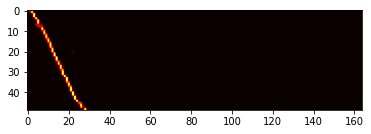

epoch 34
 batch Loss train: 0.06812302768230438
i 6
epoch 34
 batch Loss train: 0.10237010568380356
i 7
epoch 34
 batch Loss train: 0.07496677339076996
i 8
epoch 34
 batch Loss train: 0.07787665724754333
i 9
epoch 34
 batch Loss train: 0.06829310953617096
i 10
epoch 34
 batch Loss train: 0.05871625244617462
i 11
epoch 34
 batch Loss train: 0.06006461754441261
i 12
epoch 34
 batch Loss train: 0.09151437133550644
i 13
epoch 34
 batch Loss train: 0.07959397882223129
i 14
epoch 34
 batch Loss train: 0.08132600039243698
i 15
epoch 34
 batch Loss train: 0.06263109296560287
i 16
epoch 34
 batch Loss train: 0.08824190497398376
i 17
epoch 34
 batch Loss train: 0.07496140897274017
i 18
epoch 34
 batch Loss train: 0.060784414410591125
i 19
epoch 34
 batch Loss train: 0.05418098717927933
i 20
epoch 34
 batch Loss train: 0.08555647730827332
i 21
epoch 34
 batch Loss train: 0.08947954326868057
i 22
epoch 34
 batch Loss train: 0.07659327238798141
i 23
epoch 34
 batch Loss train: 0.06725216656923294
i

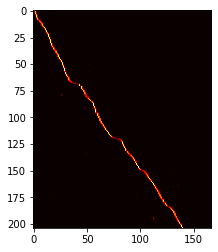

epoch 35
 batch Loss train: 0.07586728036403656
i 6
epoch 35
 batch Loss train: 0.0554778054356575
i 7
epoch 35
 batch Loss train: 0.06644833832979202
i 8
epoch 35
 batch Loss train: 0.07228713482618332
i 9
epoch 35
 batch Loss train: 0.06790081411600113
i 10
epoch 35
 batch Loss train: 0.07366997748613358
i 11
epoch 35
 batch Loss train: 0.08169601857662201
i 12
epoch 35
 batch Loss train: 0.07734636962413788
i 13
epoch 35
 batch Loss train: 0.05731385201215744
i 14
epoch 35
 batch Loss train: 0.07144796848297119
i 15
epoch 35
 batch Loss train: 0.08890434354543686
i 16
epoch 35
 batch Loss train: 0.08741538226604462
i 17
epoch 35
 batch Loss train: 0.05639104172587395
i 18
epoch 35
 batch Loss train: 0.06829386949539185
i 19
epoch 35
 batch Loss train: 0.08190000057220459
i 20
epoch 35
 batch Loss train: 0.07377250492572784
i 21
epoch 35
 batch Loss train: 0.061533283442258835
i 22
epoch 35
 batch Loss train: 0.08451047539710999
i 23
epoch 35
 batch Loss train: 0.08124462515115738
i 

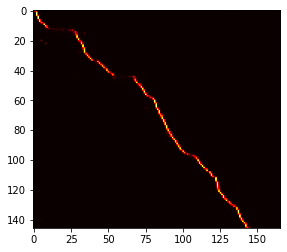

epoch 36
 batch Loss train: 0.08053100109100342
i 6
epoch 36
 batch Loss train: 0.06245715171098709
i 7
epoch 36
 batch Loss train: 0.06557504832744598
i 8
epoch 36
 batch Loss train: 0.05842282995581627
i 9
epoch 36
 batch Loss train: 0.05908772721886635
i 10
epoch 36
 batch Loss train: 0.08475249260663986
i 11
epoch 36
 batch Loss train: 0.07332292199134827
i 12
epoch 36
 batch Loss train: 0.06878187507390976
i 13
epoch 36
 batch Loss train: 0.07952719181776047
i 14
epoch 36
 batch Loss train: 0.06707831472158432
i 15
epoch 36
 batch Loss train: 0.10435260087251663
i 16
epoch 36
 batch Loss train: 0.0871119499206543
i 17
epoch 36
 batch Loss train: 0.06152136251330376
i 18
epoch 36
 batch Loss train: 0.05977417528629303
i 19
epoch 36
 batch Loss train: 0.06139695271849632
i 20
epoch 36
 batch Loss train: 0.05738241970539093
i 21
epoch 36
 batch Loss train: 0.07600824534893036
i 22
epoch 36
 batch Loss train: 0.05446430295705795
i 23
epoch 36
 batch Loss train: 0.08059398829936981
i 2

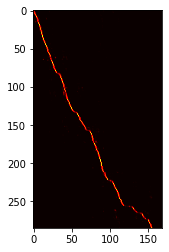

epoch 37
 batch Loss train: 0.06440165638923645
i 6
epoch 37
 batch Loss train: 0.06209155172109604
i 7
epoch 37
 batch Loss train: 0.07744200527667999
i 8
epoch 37
 batch Loss train: 0.09203527867794037
i 9
epoch 37
 batch Loss train: 0.06791818141937256
i 10
epoch 37
 batch Loss train: 0.07255711406469345
i 11
epoch 37
 batch Loss train: 0.06987844407558441
i 12
epoch 37
 batch Loss train: 0.07380315661430359
i 13
epoch 37
 batch Loss train: 0.05502351373434067
i 14
epoch 37
 batch Loss train: 0.06104952096939087
i 15
epoch 37
 batch Loss train: 0.06850754469633102
i 16
epoch 37
 batch Loss train: 0.05498264729976654
i 17
epoch 37
 batch Loss train: 0.06278635561466217
i 18
epoch 37
 batch Loss train: 0.0503082200884819
i 19
epoch 37
 batch Loss train: 0.08348836749792099
i 20
epoch 37
 batch Loss train: 0.06137657165527344
i 21
epoch 37
 batch Loss train: 0.05718701332807541
i 22
epoch 37
 batch Loss train: 0.0767158791422844
i 23
epoch 37
 batch Loss train: 0.06134815514087677
i 24

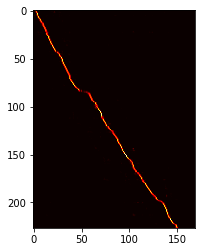

epoch 38
 batch Loss train: 0.07119713723659515
i 6
epoch 38
 batch Loss train: 0.06673600524663925
i 7
epoch 38
 batch Loss train: 0.05698151886463165
i 8
epoch 38
 batch Loss train: 0.08264164626598358
i 9
epoch 38
 batch Loss train: 0.05822056904435158
i 10
epoch 38
 batch Loss train: 0.09661649912595749
i 11
epoch 38
 batch Loss train: 0.06365904957056046
i 12
epoch 38
 batch Loss train: 0.11516101658344269
i 13
epoch 38
 batch Loss train: 0.04957905784249306
i 14
epoch 38
 batch Loss train: 0.07354772090911865
i 15
epoch 38
 batch Loss train: 0.07572612911462784
i 16
epoch 38
 batch Loss train: 0.05979248136281967
i 17
epoch 38
 batch Loss train: 0.07425511628389359
i 18
epoch 38
 batch Loss train: 0.07183374464511871
i 19
epoch 38
 batch Loss train: 0.06333578377962112
i 20
epoch 38
 batch Loss train: 0.060625672340393066
i 21
epoch 38
 batch Loss train: 0.07684431225061417
i 22
epoch 38
 batch Loss train: 0.06450367718935013
i 23
epoch 38
 batch Loss train: 0.08589113503694534
i

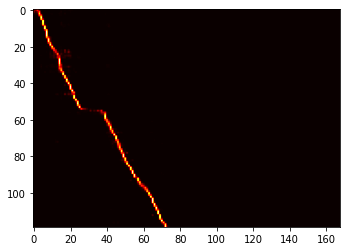

epoch 39
 batch Loss train: 0.05855626240372658
i 6
epoch 39
 batch Loss train: 0.06373461335897446
i 7
epoch 39
 batch Loss train: 0.0649111270904541
i 8
epoch 39
 batch Loss train: 0.07198148220777512
i 9
epoch 39
 batch Loss train: 0.05523471161723137
i 10
epoch 39
 batch Loss train: 0.055424198508262634
i 11
epoch 39
 batch Loss train: 0.06026478484272957
i 12
epoch 39
 batch Loss train: 0.07245011627674103
i 13
epoch 39
 batch Loss train: 0.06089167669415474
i 14
epoch 39
 batch Loss train: 0.06403791904449463
i 15
epoch 39
 batch Loss train: 0.06071283668279648
i 16
epoch 39
 batch Loss train: 0.07083941251039505
i 17
epoch 39
 batch Loss train: 0.05975694581866264
i 18
epoch 39
 batch Loss train: 0.07666882127523422
i 19
epoch 39
 batch Loss train: 0.09649235755205154
i 20
epoch 39
 batch Loss train: 0.0557711087167263
i 21
epoch 39
 batch Loss train: 0.05655496194958687
i 22
epoch 39
 batch Loss train: 0.07201242446899414
i 23
epoch 39
 batch Loss train: 0.060094673186540604
i 

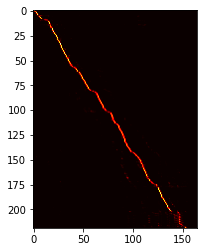

epoch 40
 batch Loss train: 0.07136183232069016
i 6
epoch 40
 batch Loss train: 0.06673822551965714
i 7
epoch 40
 batch Loss train: 0.05402594059705734
i 8
epoch 40
 batch Loss train: 0.05087535083293915
i 9
epoch 40
 batch Loss train: 0.06748586148023605
i 10
epoch 40
 batch Loss train: 0.10614852607250214
i 11
epoch 40
 batch Loss train: 0.09151864051818848
i 12
epoch 40
 batch Loss train: 0.07207073271274567
i 13
epoch 40
 batch Loss train: 0.08137670159339905
i 14
epoch 40
 batch Loss train: 0.06605258584022522
i 15
epoch 40
 batch Loss train: 0.07579843699932098
i 16
epoch 40
 batch Loss train: 0.0726976990699768
i 17
epoch 40
 batch Loss train: 0.07679171860218048
i 18
epoch 40
 batch Loss train: 0.07046355307102203
i 19
epoch 40
 batch Loss train: 0.09585867822170258
i 20
epoch 40
 batch Loss train: 0.06549093872308731
i 21
epoch 40
 batch Loss train: 0.08940489590167999
i 22
epoch 40
 batch Loss train: 0.09122858941555023
i 23
epoch 40
 batch Loss train: 0.07538019120693207
i 2

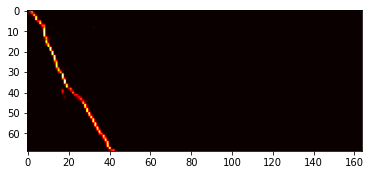

epoch 41
 batch Loss train: 0.049768224358558655
i 6
epoch 41
 batch Loss train: 0.08137614279985428
i 7
epoch 41
 batch Loss train: 0.05738838389515877
i 8
epoch 41
 batch Loss train: 0.060743529349565506
i 9
epoch 41
 batch Loss train: 0.06140298768877983
i 10
epoch 41
 batch Loss train: 0.044899944216012955
i 11
epoch 41
 batch Loss train: 0.05518065020442009
i 12
epoch 41
 batch Loss train: 0.06907325983047485
i 13
epoch 41
 batch Loss train: 0.055030666291713715
i 14
epoch 41
 batch Loss train: 0.050271861255168915
i 15
epoch 41
 batch Loss train: 0.06319793313741684
i 16
epoch 41
 batch Loss train: 0.048401765525341034
i 17
epoch 41
 batch Loss train: 0.05914914235472679
i 18
epoch 41
 batch Loss train: 0.0560772530734539
i 19
epoch 41
 batch Loss train: 0.04862174764275551
i 20
epoch 41
 batch Loss train: 0.052377764135599136
i 21
epoch 41
 batch Loss train: 0.05217632278800011
i 22
epoch 41
 batch Loss train: 0.07360716909170151
i 23
epoch 41
 batch Loss train: 0.05085061118006

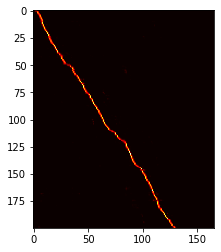

epoch 42
 batch Loss train: 0.04603531211614609
i 6
epoch 42
 batch Loss train: 0.05281311646103859
i 7
epoch 42
 batch Loss train: 0.07667049020528793
i 8
epoch 42
 batch Loss train: 0.06026419252157211
i 9
epoch 42
 batch Loss train: 0.06574621796607971
i 10
epoch 42
 batch Loss train: 0.05883261188864708
i 11
epoch 42
 batch Loss train: 0.05662843957543373
i 12
epoch 42
 batch Loss train: 0.060583338141441345
i 13
epoch 42
 batch Loss train: 0.06383325159549713
i 14
epoch 42
 batch Loss train: 0.06704653054475784
i 15
epoch 42
 batch Loss train: 0.052437130361795425
i 16
epoch 42
 batch Loss train: 0.06565558910369873
i 17
epoch 42
 batch Loss train: 0.044334590435028076
i 18
epoch 42
 batch Loss train: 0.054770976305007935
i 19
epoch 42
 batch Loss train: 0.04076994210481644
i 20
epoch 42
 batch Loss train: 0.048730626702308655
i 21
epoch 42
 batch Loss train: 0.04993118718266487
i 22
epoch 42
 batch Loss train: 0.052503615617752075
i 23
epoch 42
 batch Loss train: 0.05225592106580

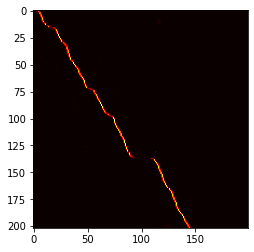

epoch 43
 batch Loss train: 0.07725723087787628
i 6
epoch 43
 batch Loss train: 0.07235720753669739
i 7
epoch 43
 batch Loss train: 0.06475019454956055
i 8
epoch 43
 batch Loss train: 0.07390428334474564
i 9
epoch 43
 batch Loss train: 0.07202677428722382
i 10
epoch 43
 batch Loss train: 0.08834250271320343
i 11
epoch 43
 batch Loss train: 0.06288710981607437
i 12
epoch 43
 batch Loss train: 0.06451836228370667
i 13
epoch 43
 batch Loss train: 0.05298528075218201
i 14
epoch 43
 batch Loss train: 0.04905618354678154
i 15
epoch 43
 batch Loss train: 0.04690495505928993
i 16
epoch 43
 batch Loss train: 0.05981391295790672
i 17
epoch 43
 batch Loss train: 0.06069875881075859
i 18
epoch 43
 batch Loss train: 0.049261175096035004
i 19
epoch 43
 batch Loss train: 0.08039457350969315
i 20
epoch 43
 batch Loss train: 0.05447627976536751
i 21
epoch 43
 batch Loss train: 0.05738700181245804
i 22
epoch 43
 batch Loss train: 0.06570975482463837
i 23
epoch 43
 batch Loss train: 0.056404706090688705


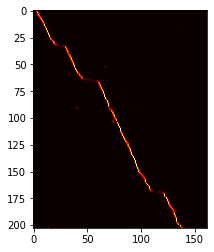

epoch 44
 batch Loss train: 0.05588068068027496
i 6
epoch 44
 batch Loss train: 0.05034920573234558
i 7
epoch 44
 batch Loss train: 0.05799315497279167
i 8
epoch 44
 batch Loss train: 0.08640074729919434
i 9
epoch 44
 batch Loss train: 0.04519657790660858
i 10
epoch 44
 batch Loss train: 0.06065082550048828
i 11
epoch 44
 batch Loss train: 0.06887051463127136
i 12
epoch 44
 batch Loss train: 0.056716229766607285
i 13
epoch 44
 batch Loss train: 0.04665264114737511
i 14
epoch 44
 batch Loss train: 0.05105898901820183
i 15
epoch 44
 batch Loss train: 0.06099432334303856
i 16
epoch 44
 batch Loss train: 0.05263053998351097
i 17
epoch 44
 batch Loss train: 0.05803212150931358
i 18
epoch 44
 batch Loss train: 0.060759689658880234
i 19
epoch 44
 batch Loss train: 0.05282650142908096
i 20
epoch 44
 batch Loss train: 0.046993110328912735
i 21
epoch 44
 batch Loss train: 0.07967105507850647
i 22
epoch 44
 batch Loss train: 0.040299009531736374
i 23
epoch 44
 batch Loss train: 0.0466343276202678

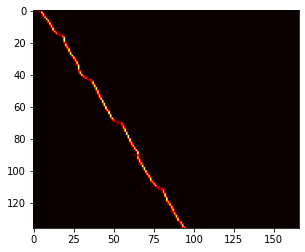

epoch 45
 batch Loss train: 0.04743105173110962
i 6
epoch 45
 batch Loss train: 0.04341655969619751
i 7
epoch 45
 batch Loss train: 0.04668029397726059
i 8
epoch 45
 batch Loss train: 0.05326712131500244
i 9
epoch 45
 batch Loss train: 0.05820237472653389
i 10
epoch 45
 batch Loss train: 0.04152049496769905
i 11
epoch 45
 batch Loss train: 0.05975916609168053
i 12
epoch 45
 batch Loss train: 0.056214481592178345
i 13
epoch 45
 batch Loss train: 0.05638880282640457
i 14
epoch 45
 batch Loss train: 0.05815981701016426
i 15
epoch 45
 batch Loss train: 0.05300465226173401
i 16
epoch 45
 batch Loss train: 0.04268999770283699
i 17
epoch 45
 batch Loss train: 0.045490752905607224
i 18
epoch 45
 batch Loss train: 0.049899693578481674
i 19
epoch 45
 batch Loss train: 0.054018713533878326
i 20
epoch 45
 batch Loss train: 0.0361555777490139
i 21
epoch 45
 batch Loss train: 0.0607793964445591
i 22
epoch 45
 batch Loss train: 0.043717317283153534
i 23
epoch 45
 batch Loss train: 0.05533920973539352

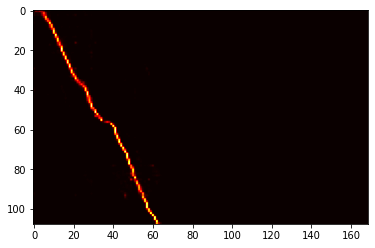

epoch 46
 batch Loss train: 0.05599714815616608
i 6
epoch 46
 batch Loss train: 0.05351872742176056
i 7
epoch 46
 batch Loss train: 0.048403315246105194
i 8
epoch 46
 batch Loss train: 0.06158355250954628
i 9
epoch 46
 batch Loss train: 0.06917154043912888
i 10
epoch 46
 batch Loss train: 0.051571544259786606
i 11
epoch 46
 batch Loss train: 0.06420835852622986
i 12
epoch 46
 batch Loss train: 0.04007987305521965
i 13
epoch 46
 batch Loss train: 0.05462655797600746
i 14
epoch 46
 batch Loss train: 0.05147281289100647
i 15
epoch 46
 batch Loss train: 0.03787592798471451
i 16
epoch 46
 batch Loss train: 0.05731013044714928
i 17
epoch 46
 batch Loss train: 0.041033998131752014
i 18
epoch 46
 batch Loss train: 0.061972588300704956
i 19
epoch 46
 batch Loss train: 0.052843425422906876
i 20
epoch 46
 batch Loss train: 0.06844905763864517
i 21
epoch 46
 batch Loss train: 0.05536624416708946
i 22
epoch 46
 batch Loss train: 0.05841986462473869
i 23
epoch 46
 batch Loss train: 0.044152412563562

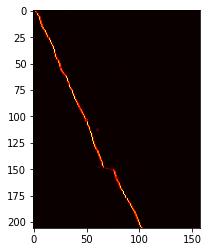

epoch 47
 batch Loss train: 0.04379225894808769
i 6
epoch 47
 batch Loss train: 0.08705158531665802
i 7
epoch 47
 batch Loss train: 0.04425494745373726
i 8
epoch 47
 batch Loss train: 0.056672919541597366
i 9
epoch 47
 batch Loss train: 0.05894706770777702
i 10
epoch 47
 batch Loss train: 0.06340805441141129
i 11
epoch 47
 batch Loss train: 0.059505511075258255
i 12
epoch 47
 batch Loss train: 0.05801188573241234
i 13
epoch 47
 batch Loss train: 0.05629779398441315
i 14
epoch 47
 batch Loss train: 0.058183614164590836
i 15
epoch 47
 batch Loss train: 0.06325210630893707
i 16
epoch 47
 batch Loss train: 0.057423416525125504
i 17
epoch 47
 batch Loss train: 0.0481235533952713
i 18
epoch 47
 batch Loss train: 0.05874459818005562
i 19
epoch 47
 batch Loss train: 0.05959424749016762
i 20
epoch 47
 batch Loss train: 0.041051674634218216
i 21
epoch 47
 batch Loss train: 0.05231522396206856
i 22
epoch 47
 batch Loss train: 0.05118648335337639
i 23
epoch 47
 batch Loss train: 0.0597682632505893

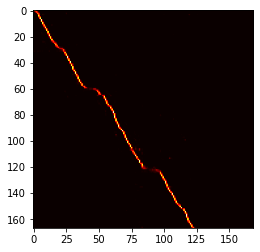

epoch 48
 batch Loss train: 0.05317401885986328
i 6
epoch 48
 batch Loss train: 0.058946117758750916
i 7
epoch 48
 batch Loss train: 0.05421118065714836
i 8
epoch 48
 batch Loss train: 0.046248674392700195
i 9
epoch 48
 batch Loss train: 0.04512946307659149
i 10
epoch 48
 batch Loss train: 0.053171075880527496
i 11
epoch 48
 batch Loss train: 0.0506550557911396
i 12
epoch 48
 batch Loss train: 0.04044535011053085
i 13
epoch 48
 batch Loss train: 0.03962096944451332
i 14
epoch 48
 batch Loss train: 0.05822792649269104
i 15
epoch 48
 batch Loss train: 0.04458010941743851
i 16
epoch 48
 batch Loss train: 0.04396837204694748
i 17
epoch 48
 batch Loss train: 0.04440827667713165
i 18
epoch 48
 batch Loss train: 0.05349106341600418
i 19
epoch 48
 batch Loss train: 0.045509256422519684
i 20
epoch 48
 batch Loss train: 0.05141369253396988
i 21
epoch 48
 batch Loss train: 0.056788865476846695
i 22
epoch 48
 batch Loss train: 0.043018266558647156
i 23
epoch 48
 batch Loss train: 0.047029592096805

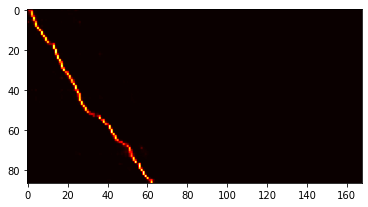

epoch 49
 batch Loss train: 0.04431162774562836
i 6
epoch 49
 batch Loss train: 0.04781636223196983
i 7
epoch 49
 batch Loss train: 0.04427238926291466
i 8
epoch 49
 batch Loss train: 0.04204448685050011
i 9
epoch 49
 batch Loss train: 0.054482318460941315
i 10
epoch 49
 batch Loss train: 0.04608890414237976
i 11
epoch 49
 batch Loss train: 0.036351241171360016
i 12
epoch 49
 batch Loss train: 0.04040446877479553
i 13
epoch 49
 batch Loss train: 0.03529305011034012
i 14
epoch 49
 batch Loss train: 0.05042695626616478
i 15
epoch 49
 batch Loss train: 0.054952774196863174
i 16
epoch 49
 batch Loss train: 0.05254345014691353
i 17
epoch 49
 batch Loss train: 0.05909129977226257
i 18
epoch 49
 batch Loss train: 0.05115346610546112
i 19
epoch 49
 batch Loss train: 0.052855394780635834
i 20
epoch 49
 batch Loss train: 0.04373086988925934
i 21
epoch 49
 batch Loss train: 0.03335459530353546
i 22
epoch 49
 batch Loss train: 0.07996252924203873
i 23
epoch 49
 batch Loss train: 0.0361596904695034

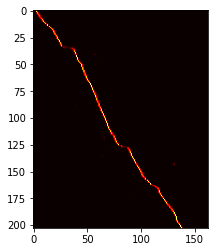

epoch 50
 batch Loss train: 0.039785683155059814
i 6
epoch 50
 batch Loss train: 0.05065523087978363
i 7
epoch 50
 batch Loss train: 0.047818366438150406
i 8
epoch 50
 batch Loss train: 0.03690161928534508
i 9
epoch 50
 batch Loss train: 0.043420594185590744
i 10
epoch 50
 batch Loss train: 0.04281352460384369
i 11
epoch 50
 batch Loss train: 0.05459708720445633
i 12
epoch 50
 batch Loss train: 0.03981609269976616
i 13
epoch 50
 batch Loss train: 0.043802689760923386
i 14
epoch 50
 batch Loss train: 0.03744988888502121
i 15
epoch 50
 batch Loss train: 0.05024275556206703
i 16
epoch 50
 batch Loss train: 0.037223752588033676
i 17
epoch 50
 batch Loss train: 0.04006525129079819
i 18
epoch 50
 batch Loss train: 0.05158424749970436
i 19
epoch 50
 batch Loss train: 0.05254293978214264
i 20
epoch 50
 batch Loss train: 0.03621561825275421
i 21
epoch 50
 batch Loss train: 0.03772955387830734
i 22
epoch 50
 batch Loss train: 0.037878651171922684
i 23
epoch 50
 batch Loss train: 0.06327953934669

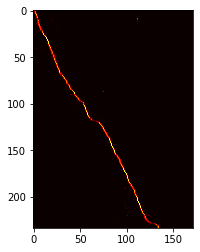

epoch 51
 batch Loss train: 0.036767780780792236
i 6
epoch 51
 batch Loss train: 0.046348173171281815
i 7
epoch 51
 batch Loss train: 0.05300629884004593
i 8
epoch 51
 batch Loss train: 0.05060179531574249
i 9
epoch 51
 batch Loss train: 0.0428592823445797
i 10
epoch 51
 batch Loss train: 0.043823469430208206
i 11
epoch 51
 batch Loss train: 0.07333460450172424
i 12
epoch 51
 batch Loss train: 0.05013120546936989
i 13
epoch 51
 batch Loss train: 0.04251449927687645
i 14
epoch 51
 batch Loss train: 0.04288971424102783
i 15
epoch 51
 batch Loss train: 0.04667087644338608
i 16
epoch 51
 batch Loss train: 0.04920974001288414
i 17
epoch 51
 batch Loss train: 0.05920998752117157
i 18
epoch 51
 batch Loss train: 0.04883265867829323
i 19
epoch 51
 batch Loss train: 0.04045550897717476
i 20
epoch 51
 batch Loss train: 0.04987749084830284
i 21
epoch 51
 batch Loss train: 0.045501336455345154
i 22
epoch 51
 batch Loss train: 0.05553865805268288
i 23
epoch 51
 batch Loss train: 0.04191666841506958

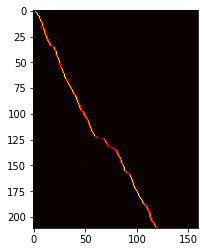

epoch 52
 batch Loss train: 0.05510023608803749
i 6
epoch 52
 batch Loss train: 0.0327686071395874
i 7
epoch 52
 batch Loss train: 0.0523262619972229
i 8
epoch 52
 batch Loss train: 0.045597631484270096
i 9
epoch 52
 batch Loss train: 0.05221695452928543
i 10
epoch 52
 batch Loss train: 0.041054416447877884
i 11
epoch 52
 batch Loss train: 0.045557744801044464
i 12
epoch 52
 batch Loss train: 0.03750133886933327
i 13
epoch 52
 batch Loss train: 0.06051325798034668
i 14
epoch 52
 batch Loss train: 0.047225821763277054
i 15
epoch 52
 batch Loss train: 0.05431489646434784
i 16
epoch 52
 batch Loss train: 0.037449173629283905
i 17
epoch 52
 batch Loss train: 0.058054253458976746
i 18
epoch 52
 batch Loss train: 0.06774483621120453
i 19
epoch 52
 batch Loss train: 0.05310089886188507
i 20
epoch 52
 batch Loss train: 0.04713006317615509
i 21
epoch 52
 batch Loss train: 0.051172565668821335
i 22
epoch 52
 batch Loss train: 0.059825897216796875
i 23
epoch 52
 batch Loss train: 0.04744568094611

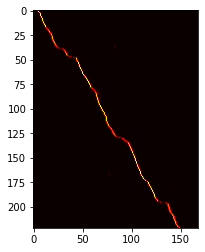

epoch 53
 batch Loss train: 0.05048660933971405
i 6
epoch 53
 batch Loss train: 0.045689500868320465
i 7
epoch 53
 batch Loss train: 0.051332734525203705
i 8
epoch 53
 batch Loss train: 0.03832632303237915
i 9
epoch 53
 batch Loss train: 0.04896659404039383
i 10
epoch 53
 batch Loss train: 0.049854397773742676
i 11
epoch 53
 batch Loss train: 0.049099795520305634
i 12
epoch 53
 batch Loss train: 0.05552205443382263
i 13
epoch 53
 batch Loss train: 0.05026334151625633
i 14
epoch 53
 batch Loss train: 0.06092418357729912
i 15
epoch 53
 batch Loss train: 0.03458515182137489
i 16
epoch 53
 batch Loss train: 0.0615377239882946
i 17
epoch 53
 batch Loss train: 0.050698958337306976
i 18
epoch 53
 batch Loss train: 0.07358664274215698
i 19
epoch 53
 batch Loss train: 0.035215962678194046
i 20
epoch 53
 batch Loss train: 0.049183908849954605
i 21
epoch 53
 batch Loss train: 0.043117981404066086
i 22
epoch 53
 batch Loss train: 0.03327842801809311
i 23
epoch 53
 batch Loss train: 0.0362796336412

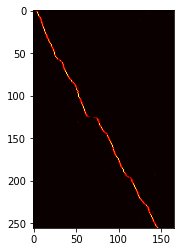

epoch 54
 batch Loss train: 0.042750272899866104
i 6
epoch 54
 batch Loss train: 0.054298125207424164
i 7
epoch 54
 batch Loss train: 0.055233996361494064
i 8
epoch 54
 batch Loss train: 0.052591025829315186
i 9
epoch 54
 batch Loss train: 0.054688189178705215
i 10
epoch 54
 batch Loss train: 0.043427787721157074
i 11
epoch 54
 batch Loss train: 0.0417814739048481
i 12
epoch 54
 batch Loss train: 0.0569637194275856
i 13
epoch 54
 batch Loss train: 0.04775550961494446
i 14
epoch 54
 batch Loss train: 0.036620013415813446
i 15
epoch 54
 batch Loss train: 0.055892884731292725
i 16
epoch 54
 batch Loss train: 0.03386606648564339
i 17
epoch 54
 batch Loss train: 0.033018808811903
i 18
epoch 54
 batch Loss train: 0.05449729785323143
i 19
epoch 54
 batch Loss train: 0.042510878294706345
i 20
epoch 54
 batch Loss train: 0.050912775099277496
i 21
epoch 54
 batch Loss train: 0.058999884873628616
i 22
epoch 54
 batch Loss train: 0.04940309748053551
i 23
epoch 54
 batch Loss train: 0.0269006062299

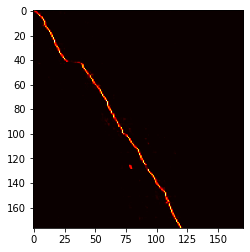

epoch 55
 batch Loss train: 0.03658415377140045
i 6
epoch 55
 batch Loss train: 0.04067588970065117
i 7
epoch 55
 batch Loss train: 0.039723947644233704
i 8
epoch 55
 batch Loss train: 0.04184180498123169
i 9
epoch 55
 batch Loss train: 0.043473802506923676
i 10
epoch 55
 batch Loss train: 0.04747215285897255
i 11
epoch 55
 batch Loss train: 0.03212731331586838
i 12
epoch 55
 batch Loss train: 0.05357293784618378
i 13
epoch 55
 batch Loss train: 0.03842999413609505
i 14
epoch 55
 batch Loss train: 0.04482002928853035
i 15
epoch 55
 batch Loss train: 0.04078539460897446
i 16
epoch 55
 batch Loss train: 0.03384366258978844
i 17
epoch 55
 batch Loss train: 0.05312857776880264
i 18
epoch 55
 batch Loss train: 0.048506688326597214
i 19
epoch 55
 batch Loss train: 0.05236359313130379
i 20
epoch 55
 batch Loss train: 0.037630509585142136
i 21
epoch 55
 batch Loss train: 0.04805572330951691
i 22
epoch 55
 batch Loss train: 0.05238929018378258
i 23
epoch 55
 batch Loss train: 0.0355315282940864

In [ ]:
CUDA_LAUNCH_BLOCKING=1
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torch.nn.utils.rnn import *
#from models import Seq2Seq
#from train_test import train, test
#from dataloader import load_data, collate_train, collate_test, transform_letter_to_index, Speech2TextDataset

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

LETTER_LIST = ['<pad>', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', \
               'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '-', "'", '.', '_', '+', ' ','<sos>','<eos>']


model = Seq2Seq(input_dim=40, vocab_size=len(LETTER_LIST), hidden_dim = 512)
model = model.to(DEVICE)
#model.load_state_dict(torch.load('/content/gdrive/MyDrive/11785/recitation08part02/hw4model_epoch_25'))
#torch.save(model.state_dict(),'hw4model_epoch12.pth')
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(reduction='none')
nepochs = 30
batch_size = 64 if DEVICE == 'cuda' else 1

speech_train, speech_valid, speech_test, transcript_train, transcript_valid = load_data()
print(speech_train[0].shape)
character_text_train = transform_letter_to_index(transcript_train, LETTER_LIST)
character_text_valid = transform_letter_to_index(transcript_valid, LETTER_LIST)

train_dataset = Speech2TextDataset(speech_train, character_text_train)

val_dataset = Speech2TextDataset(speech_valid, character_text_valid)

test_dataset = Speech2TextDataset(speech_test, None, False)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_train)
print(len(train_loader))
#print(train_dataset.shape)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_train)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_test)

for epoch in range(nepochs):
    train(model, train_loader, criterion, optimizer, epoch)
    #val(model, val_loader)
    torch.save(model.state_dict(),"./exp2/hw4model_epoch_{}".format(epoch+1))
#test(model, test_loader, epoch)




# saving model

In [ ]:
torch.save(model.state_dict(),'hw4model_epoch12.pth')

NameError: ignored

In [ ]:
if __name__ == '__main__':
  print(main.model)

AttributeError: ignored

In [ ]:
print(DEVICE)
print(device)

cuda
cuda


In [ ]:
import numpy as np
transcript_train = np.load('./data/train_transcripts.npy', allow_pickle=True,encoding='bytes')
k=transcript_train[0][1].decode()
print(transcript_train[0][0])
sentence = transcript_train[0]
for c in k:
  print(LETTER_LIST.index(c))
print(transcript_train[0].shape)
sent=""
for word in sentence:
          word = word.decode()
          sent+=(word+ ' ')

sent = sent[:-1]
lst = []
lst.append(LETTER_LIST.index('<sos>'))
for c in sent:
  lst.append(LETTER_LIST.index(c)) 
lst.append(LETTER_LIST.index('<eos>'))
print(len(lst))
print(len(sent))


b'he'
8
1
4
(43,)
227
225


In [ ]:
letter_to_index = []
for sentence in transcript_train:
    sent=""
    for word in sentence:
      word = word.decode()
      sent+=(word + ' ')
    sent = sent[:-1]
    lst = []
    for c in sent:
      lst.append(LETTER_LIST.index(c))
    letter_to_index.append(lst)
print(len(letter_to_index[0]))

225


In [ ]:
s = " i mmm mc"
s = s[:-4]
print(len(s))

5
